In [1]:
import pandas as pd
import numpy as np

from optbinning import OptimalBinning
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

(CVXPY) Aug 02 12:00:59 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Aug 02 12:00:59 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [2]:
import warnings
warnings.filterwarnings('ignore')

#解决输出结果展示不全问题
# pd.set_option('max_row',350)
# pd.set_option('max_columns', 200)

#pandas新版本set_option被禁用
pd.options.display.max_rows= 350
pd.options.display.max_columns = 200

#同时展示多个结果
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

In [3]:
#去同一值占比过高字段
def qu_tyz(data, var_not, a=0.9):
    all_var=data.columns
    sd=data.shape[0]
    zs_var=list(set(all_var)-set(var_not))
    paichu=[]
    for i in zs_var:
        c=max(data[i].value_counts())
        if c/sd>a:
            paichu.append(i)
    var_drop=paichu
    return var_drop

#欠采样
def random_undersampler(df, target, rate=0.1, stratify_fea=None, replace=False):
    '''
    ---负样本下采样函数---
    df: 训练样本数据, 数据框格式
    rate: 负样本与正样本的比值
    target: 样本标签列
    replace: replace=False表示无放回抽样，反之表示又放回抽样
    '''
    pos_df = df[df[target]==1]
    neg_df = df[df[target]==0]
    N = pos_df.shape[0]
    num_neg = int(N/rate)-N
    if stratify_fea is None:
        neg_df_sample = neg_df.sample(n=num_neg, replace=replace)
    else:
        neg_df_sample = pd.DataFrame()
        cats = df[stratify_fea].unique()
        for cat in cats:
            cat_N = pos_df[pos_df[stratify_fea]==cat].shape[0]
            cat_num_neg = int(cat_N/rate)-cat_N
            cat_neg_df_sample = neg_df[neg_df[stratify_fea]==cat].sample(n=cat_num_neg, replace=replace)
            neg_df_sample = pd.concat([neg_df_sample, cat_neg_df_sample])
        
    df_sample = pd.concat([pos_df, neg_df_sample])
    return df_sample



# #IV计算
# def get_iv(df, fea, y, bins=10):
#     df_iv =df.copy()
#     if df_iv[fea].nunique()<=1:
#         iv=0
#         stat=None
#     else:
#         df_iv['bins'] = pd.qcut (df_iv[fea], bins, duplicates='drop', precision=3)
#         stat = df_iv.groupby(['bins']).agg({'bins':'count', y:'sum'})
#         stat.index= stat.index.astype('str')
#         stat.columns = ['all','bad']
#         if df_iv[df_iv['bins'].isnull()][y].count()>0:
#             nan_num = df_iv[df_iv['bins'].isnull()][y].count()
#             nan_1_num = df_iv[df_iv['bins'].isnull()][y].sum()
#             nan_df = pd.DataFrame({'all':[nan_num], 'bad':[nan_1_num]})
#             nan_df.index =['Nan']
#             stat = pd.concat([stat, nan_df])
#         stat['good'] = stat['all'] - stat['bad']
#         stat['badRate'] = stat['bad'] / stat['all']
#         stat['good%'] = stat.good / stat.good.sum()
#         stat['bad%'] = stat.bad / stat.bad.sum()
#         stat['good%'] = stat['good%'].replace(0.0, 0.00001)
#         stat['bad%'] = stat['bad'].replace(0.0, 0.00001)
#         stat['woe'] = np.log(stat['good%']/stat['bad%'])
#         rate_m = stat['good%'] - stat['bad%']

#         iv = np.sum (rate_m * stat.woe)

#     return iv, stat


In [4]:
#计算PSI
import math

def calculate_psi(base_df, test_df, bins=10, min_sample=10, numerical=True):
    '''
    base_df: 基期数据，DataFrame格式
    test_df：观测期数据，DataFrame格式
    bins：连续型变量分箱数量，等频分箱；也可直接传入分箱节点列表
    min_sample：每项数据中最小样本量
    numerical：计算PSI的数据是否为连续型变量，是连续型为True, 类别型False
    '''
    if base_df.shape[0]==0 or test_df.shape[0]==0:
        print('error!!!')
        psi = np.nan
        stat_df = None
    else:
        base_df.columns=['score']
        test_df.columns=['score']

        base_notnull_cnt = len(list(base_df['score'].dropna()))
        test_notnull_cnt = len(list(test_df['score'].dropna()))

        base_null_cnt = len(base_df) - base_notnull_cnt
        test_null_cnt = len(test_df) - test_notnull_cnt

        if numerical:
            q_list = []
            if type(bins) == int:
                bin_num = min(bins, int(base_notnull_cnt/min_sample))
                q_list = [x / bin_num for x in range(1, bin_num)]
                break_list = []
                for q in q_list:
                    bk = base_df['score'].quantile(q)
                    break_list.append(bk)
                break_list = sorted(list(set(break_list)))
                score_bin_list = [-np.inf] + break_list + [np.inf]
            else:
                score_bin_list = bins   #可传入分箱节点

            base_cnt_list = [base_null_cnt]
            test_cnt_list = [test_null_cnt]
            bucket_list = ['MISSING']
            for i in range(len(score_bin_list)-1):
                left = round(score_bin_list[i+0], 4)
                right = round(score_bin_list[i+1], 4)
                bucket_list.append('(' + str(left) + ',' + str(right) + ']')

                base_cnt = base_df[(base_df.score>left) & (base_df.score<=right)].shape[0]
                base_cnt_list.append(base_cnt)

                test_cnt = test_df[(test_df.score>left) & (test_df.score<=right)].shape[0]
                test_cnt_list.append(test_cnt)

            stat_df = pd.DataFrame({'bucket': bucket_list, 'base_cnt': base_cnt_list, 'test_cnt': test_cnt_list})
            stat_df['base_dist'] = stat_df['base_cnt']/len(base_df)
            stat_df['test_dist'] = stat_df['test_cnt']/len(test_df)
        else:
            base_cnt_list = [base_null_cnt]
            test_cnt_list = [test_null_cnt]
            bucket_list = ['MISSING']
            stat_df = pd.DataFrame({'bucket': bucket_list, 'base_cnt': base_cnt_list, 'test_cnt': test_cnt_list})
            cat_df = pd.concat([base_df.score.value_counts(), test_df.score.value_counts()], axis=1).reset_index()
            cat_df.columns = ['bucket', 'base_cnt', 'test_cnt']
            stat_df = pd.concat([stat_df, cat_df])
            stat_df['base_dist'] = stat_df['base_cnt']/len(base_df)
            stat_df['test_dist'] = stat_df['test_cnt']/len(test_df)

        def sub_psi(row):
            base_list = row['base_dist']
            test_list = row['test_dist']

            if base_list==0 and test_list==0:
                return 0
            elif base_list==0 and test_list > 0:
                base_list = 1/base_notnull_cnt
            elif base_list > 0 and test_list==0:
                test_list = 1/test_notnull_cnt
            return (test_list - base_list)* np.log(test_list/base_list)
        
        stat_df['psi'] = stat_df.apply(lambda row: sub_psi(row), axis=1)
        stat_df = stat_df[['bucket', 'base_cnt', 'base_dist', 'test_cnt', 'test_dist', 'psi']]
        psi = stat_df['psi'].sum()
    
    return psi, stat_df

In [5]:
#最终模型分测算，依据qcut自动分箱
def lift_ks1(df, score, y, sort=False):
    if sort==True:#降序排列，分最高的一箱再细分10箱
        df['bins_0'] = pd.qcut(df[score],10,duplicates='drop',precision=1)
        df['bins_1'] = pd.qcut(df[df['bins_0']==df['bins_0'].max()][score], 10, duplicates='drop', precision=1)
        df['bins'] = np.where(df['bins_1'].notnull(), df['bins_1'], df['bins_0'])
        stat = df.groupby(['bins']).agg({'bins':'count', y:'sum'}).sort_index(ascending=False)
    else:#正序排列，分最低的一箱再细分10箱
        df['bins_0'] = pd.qcut(df[score], 10, duplicates='drop', precision=1)
        df['bins_1'] = pd.qcut(df[df['bins_0']==df['bins_0'].min()][score], 10, duplicates='drop', precision=1)
        df['bins'] = np.where(df['bins_1'].notnull(), df['bins_1'], df['bins_0'])
        stat = df.groupby(['bins']).agg({'bins':'count',y:'sum'})
    stat.columns = ['all','bad']
    if df[df['bins'].isnull()][y].count()>0:#处理空值
        nan_num = df[df['bins'].isnull()][y].count()
        nan_1_num = df[df['bins'].isnull()][y].sum()
        nan_df = pd.DataFrame([nan_num,nan_1_num]).T
        nan_df.columns = ['all','bad']
        nan_df.index = ['Nan']
        stat = pd.concat([stat, nan_df])
        
    stat['good'] = stat['all'] - stat['bad']
    stat = stat[['bad', 'good' ,'all']]
    stat['BadRate'] = stat['bad'] / stat['all']
    stat['Bad_CumRate'] = stat['bad'].cumsum() / stat['bad'].sum()
    stat['Good_CumRate'] = stat['good'].cumsum() / stat['good'].sum()
    stat['all_CumRate'] = stat['all'].cumsum() / stat['all'].sum()
    stat['all_Rate'] = stat['all'] / stat['all'].sum()
    
    all_num = stat['all'].sum()
    all_1_num = stat['bad'].sum()
    all_0_num = stat['good'].sum()
    all_bad_rate = all_1_num / all_num
    
    stat['ks'] = abs(stat['Bad_CumRate'] - stat['Good_CumRate'])
    stat['lift'] = stat['BadRate'] / all_bad_rate
    stat['cum_lift'] = (stat['bad'].cumsum()/stat['all'].cumsum()) / all_bad_rate
    
    hj_df = pd.DataFrame([all_1_num, all_0_num, all_num, all_bad_rate, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]).T
    hj_df.columns = ['bad', 'good', 'all', 'BadRate', 'Bad_CumRate', 'Good_CumRate', 'all_CumRate', 'all_Rate', 'ks', 'lift', 'cum_lift']
    hj_df.index=['All']
    all_stat = pd.concat([stat, hj_df])
    return all_stat

In [6]:
def binary_metric(target, pred, threshold=0.5):
    '''
    ---二分类数据模型评价函数---
    target: 样本真实标签
    pred: 样本预测概率值
    threshold: 概率阈值
    '''
    pred_ = (pred>=threshold)*1
    accuracy = accuracy_score(target, pred_)     #accuracy_score准确率
    precision = precision_score(target, pred_)   #precision_score精确率
    recall = recall_score(target, pred_)         #recall_score召回率
    f1_measure = f1_score(target, pred_)         #f1_score  f1得分
    confusionMatrix = confusion_matrix(target, pred_)     #confusion_matrix  混淆矩阵
    fpr, tpr, thresholds = roc_curve(target, pred, pos_label=1)   #roc_curve ROC曲线
    auc = roc_auc_score(target, pred)     #roc_auc_score  AUC面积
    KS = max(abs(tpr-fpr))
    TP = confusionMatrix[1, 1]
    FP = confusionMatrix[0, 1]
    FN = confusionMatrix[1, 0]
    TN = confusionMatrix[0, 0]
    lift = (TP/(TP+FP))/((TP+FN)/(TP+FP+FN+TN))
    MAP = average_precision_score(target, pred)    #average_precision_score

    print ("------------------------- ")
    print ("confusion matrix:")
    print ("------------------------- ")
    print ("| TP: %5d | FP: %5d |" % (confusionMatrix[1, 1], confusionMatrix[0, 1]))
    print ("----------------------- ")
    print ("| FN: %5d | TN: %5d |" % (confusionMatrix[1, 0], confusionMatrix[0, 0]))
    print (" ------------------------- ")
    print ("Accuracy:       %.2f%%" % (accuracy * 100))
    print ("Recall:         %.2f%%" % (recall * 100))
    print ("Precision:      %.2f%%" % (precision * 100))
    print ("F1-measure:     %.2f%%" % (f1_measure * 100))
    print ("AUC:            %.2f%%" % (auc * 100))
    print ("KS:             %.2f%%" % (KS * 100))
    print ("lift:           %.2f%%" % (lift * 100))
    print ("MAP:            %.2f%%" % (MAP * 100))
    print ("------------------------- ")
    # return (auc)

In [7]:
df_220412 = pd.read_csv(r'回溯数据结果20220412.csv', encoding='gbk')

In [8]:
df_220412.head()

,md5_mobile,回溯日期,会员id,是否收单,年龄,年龄范围,性别,手机号归属省份,手机号归属城市,手机号归属地城市等级,身份证归属省份,身份证归属城市,身份证归属地城市等级,会员注册时间,会员注册时长(天),是否三要素会员,优选会员等级,会员协议公司名称,会员协议公司规模,会员协议公司企业卡等级,会员协议公司行业,会员协议公司省份,会员协议公司城市,历史会员涉及礼包销售次数,历史会员涉及礼包总金额,近一年会员涉及礼包销售次数,近一年会员涉及礼包总金额,近3月会员涉及礼包销售次数,近3月会员涉及礼包总金额,历史铂物馆订单数,历史铂物馆订单商品数,历史铂物馆总售价,历史铂物馆订单平均售价（订单级）,历史铂物馆订单商品平均售价（商品级）,近一年铂物馆订单数,近一年铂物馆订单商品数,近一年铂物馆总售价,近一年铂物馆订单平均售价（订单级）,近一年铂物馆订单商品平均售价（商品级）,近3月铂物馆订单数,近3月铂物馆订单商品数,近3月铂物馆总售价,近3月铂物馆订单平均售价（订单级）,近3月铂物馆订单商品平均售价（商品级）,最近一次预订酒店距今时长,最近一次预订酒店实付金额,最近一次预订酒店星级,历史会员预定酒店次数,历史会员订单实付总金额,历史会员预订平均订单金额,历史会员总预订房晚数,历史会员预订星级酒店的次数,历史会员预订星级酒店的总金额,历史会员预订酒店涉及城市个数,历史会员预订酒店涉及城市平均等级,历史使用协议公司预订酒店次数,历史预订酒店涉及协议公司个数,近一年会员预定酒店次数,近一年会员订单实付总金额,近一年会员预订平均订单金额,近一年会员总预订房晚数,近一年会员预订星级酒店的次数,近一年会员预订星级酒店的总金额,近一年会员预订酒店涉及城市个数,近一年会员预订酒店涉及城市平均等级,近一年使用协议公司预订酒店次数,近一年预订酒店涉及协议公司个数,近3月会员预定酒店次数,近3月会员订单实付总金额,近3月会员预订平均订单金额,近3月会员总预订房晚数,近3月会员预订星级酒店的次数,近3月会员预订星级酒店的总金额,近3月会员预订酒店涉及城市个数,近3月会员预订酒店涉及城市平均等级,近3月使用协议公司预订酒店次数,近3月预订酒店涉及协议公司个数,近3月使用积分数,近3月获取积分数,近一年使用积分数,近一年获取积分数,历史使用积分数,历史获取积分数,月底积分余额,历史免费房的预订次数,近一年免费房的预订次数,近3月免费房的预订次数,近一年使用优惠券总金额,近一年使用优惠券平均金额,近一年会员订单优惠金额占订单总价比例,近3月使用优惠券总金额,近3月使用优惠券平均金额,近3月会员订单优惠金额占订单总价比例
0,05592b7af921dd79e06b38ea26346964,20220320,17893,0,72,>60,男,NaN,NaN,NaN,广东,广州,一线,NaN,NaN,N,V4,客服中心测试企业卡,100人以下,商务,民营,NaN,NaN,0,0,0,0,0,0,89,101,1876.94,21.089213,18.583564,28,38,1026.86,36.673571,27.022632,1,2,127.68,127.68,63.84,11.0,0.0,无星,280,67726.0,241.878571,355.0,3,4918.0,63,一线城市,10,3,111,31317.0,282.135135,131.0,1,3980.0,35,一线城市,8,3,16,6620.0,413.75,16.0,1,3980.0,10,一线城市,2,1,12000,20011,1133634,234203,1146253,238707,8094.0,74.0,15.0,3.0,7430.0,125.932203,0.164039,1608.0,201.0,0.276621
1,35efe261ab1b663b5b40eb23bd540a27,20220320,950190,0,39,36-50,男,广东,惠州,二线,河南,NaN,NaN,NaN,NaN,Y,V4,NaN,NaN,优享,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0.00,NaN,NaN,0,0,0.00,NaN,NaN,0,0,0.00,NaN,NaN,16.0,269.0,无星,231,54119.0,234.281385,280.0,0,0.0,11,三线城市,0,0,13,3795.0,291.923077,23.0,0,0.0,3,四线城市,0,0,1,269.0,269.00,1.0,0,0.0,1,二线城市,0,0,0,100,0,28050,0,28050,34018.0,11.0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000
2,99e592cc486264d8a7246216bb7fc9b3,20220320,2293766,1,37,36-50,男,上海,上海,一线,福建,NaN,NaN,NaN,NaN,Y,V2,NaN,NaN,优享,NaN,NaN,NaN,1,99,0,0,0,0,0,0,0.00,NaN,NaN,0,0,0.00,NaN,NaN,0,0,0.00,NaN,NaN,153.0,237.0,无星,3,721.0,240.333333,3.0,0,0.0,1,一线城市,0,0,1,237.0,237.000000,1.0,0,0.0,1,一线城市,0,0,0,0.0,NaN,NaN,0,0.0,0,NaN,0,0,0,0,0,100,0,278,278.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000
3,c4dcce537a344982caeaef84cc2f2d7d,20220320,5277716,1,38,36-50,男,广东,深圳,一线,新疆,阿克苏地区,五线,NaN,NaN,Y,V3,NaN,NaN,优享,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0.00,NaN,NaN,0,0,0.00,NaN,NaN,0,0,0.00,NaN,NaN,195.0,140.0,无星,38,11907.0,313.342105,55.0,0,0.0,13,二线城市,0,0,14,3230.0,230.714286,15.0,0,0.0,5,二线城市,0,0,0,0.0,NaN,NaN,0,0.0,0,NaN,0,0,0,0,0,2053,0,2438,9639.0,NaN,NaN,NaN,50.0,25.000000,0.005064,NaN,NaN,0.000000
4,a069903738c17b39be236c2f5c28f1cb,20220320,7372396,0,34,27-35,男,广东,惠州,二线,广东,惠州,二线,NaN,NaN,Y,V4,NaN,NaN,优享,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0.00,NaN,NaN,0,0,0.00,NaN,NaN,0,0,0.00,NaN,NaN,27.0,0.0,无星,193,66471.0,344.409326,242.0,0,0.0,11,一线城市,1,1,8,2558.0,319.750000,13.0,0,0.0,5,二线城市,1,1,1,0.0,0.00,1.0,0,0.0,1,一线城市,0,0,16000,0,36000,3757,44000,3757,2176.0,8.0,3.0,1.0,NaN,NaN,0.000000,NaN,NaN,0.000000


In [9]:
df_220412.columns

Index(['md5_mobile', '回溯日期', '会员id', '是否收单', '年龄', '年龄范围', '性别', '手机号归属省份',
       '手机号归属城市', '手机号归属地城市等级', '身份证归属省份', '身份证归属城市', '身份证归属地城市等级', '会员注册时间',
       '会员注册时长(天)', '是否三要素会员', '优选会员等级', '会员协议公司名称', '会员协议公司规模', '会员协议公司企业卡等级',
       '会员协议公司行业', '会员协议公司省份', '会员协议公司城市', '历史会员涉及礼包销售次数', '历史会员涉及礼包总金额',
       '近一年会员涉及礼包销售次数', '近一年会员涉及礼包总金额', '近3月会员涉及礼包销售次数', '近3月会员涉及礼包总金额',
       '历史铂物馆订单数', '历史铂物馆订单商品数', '历史铂物馆总售价', '历史铂物馆订单平均售价（订单级）',
       '历史铂物馆订单商品平均售价（商品级）', '近一年铂物馆订单数', '近一年铂物馆订单商品数', '近一年铂物馆总售价',
       '近一年铂物馆订单平均售价（订单级）', '近一年铂物馆订单商品平均售价（商品级）', '近3月铂物馆订单数', '近3月铂物馆订单商品数',
       '近3月铂物馆总售价', '近3月铂物馆订单平均售价（订单级）', '近3月铂物馆订单商品平均售价（商品级）', '最近一次预订酒店距今时长',
       '最近一次预订酒店实付金额', '最近一次预订酒店星级', '历史会员预定酒店次数', '历史会员订单实付总金额',
       '历史会员预订平均订单金额', '历史会员总预订房晚数', '历史会员预订星级酒店的次数', '历史会员预订星级酒店的总金额',
       '历史会员预订酒店涉及城市个数', '历史会员预订酒店涉及城市平均等级', '历史使用协议公司预订酒店次数',
       '历史预订酒店涉及协议公司个数', '近一年会员预定酒店次数', '近一年会员订单实付总金额', '近一年会员预订平均订单金额',
       '近一年会员总预订房晚数', '近一年会员预订星级酒店的次数', '近一年会员预订星级酒

In [10]:
df_220412.shape
df_220412['md5_mobile'].nunique()
df_220412['是否收单'].value_counts()

是否收单
0    49724
1      633
Name: count, dtype: int64

In [11]:
#删除无意义字段
df_220412 = df_220412.drop(['md5_mobile', '回溯日期', '会员id', '会员注册时间'], axis=1)

In [12]:
#删除缺失率>=0.9的列
df_220412 = df_220412.drop(list(df_220412.isnull().mean()[df_220412.isnull().mean()>=0.9].index), axis=1)

In [13]:
#去同一值占比过高字段
def qu_tyz(data, var_not, a=0.9):
    all_var=data.columns
    sd=data.shape[0]
    zs_var=list(set(all_var)-set(var_not))
    paichu=[]
    for i in zs_var:
        c=max(data[i].value_counts())
        if c/sd>a:
            paichu.append(i)
    var_drop=paichu
    return var_drop

var_drop = qu_tyz(df_220412, var_not=['是否收单'], a=0.9)
var_drop
df_220412 = df_220412.drop(var_drop, axis=1)

In [14]:
y = '是否收单'
numerical_col = df_220412.drop(columns=[y]).dtypes[df_220412.drop(columns=[y]).dtypes!='object'].index.values
categorical_col = df_220412.drop(columns=[y]).dtypes[df_220412.drop(columns=[y]).dtypes=='object'].index.values
len(numerical_col)
len(categorical_col)

13

In [15]:
#分层抽样划分训练测试集
train, test=train_test_split(df_220412, test_size=0.3, stratify=df_220412['是否收单'], random_state=1234)
x_train = train.drop('是否收单', axis=1)
y_train = train['是否收单']
x_test = test.drop('是否收单', axis=1)
y_test = test['是否收单']

x_train.shape
x_test.shape
y_train.sum()
y_test.sum()

190

In [24]:
# %%capture   #不展示运行过程

x_train_copy = x_train.copy()
x_test_copy = x_test.copy()
# x_oot_copy = x_oot.copy()

split_dict = {}
var_woe_df = pd.DataFrame()

for variable in categorical_col:
    optb = OptimalBinning(name=variable,
                          monotonic_trend='auto_asc_desc',
                          dtype='categorical',
                          min_bin_n_nonevent=10,
                          min_bin_n_event=10,
                          max_n_bins=6,
                          min_prebin_size=0.05
                          )
    optb.fit(x_train[variable], y_train)
    x_train_copy[variable] = optb.transform(x_train_copy[variable], metric='woe',
                                             metric_missing='empirical') * -1
    x_test_copy[variable] = optb.transform(x_test_copy[variable], metric='woe',
                                            metric_missing='empirical') * -1
    # x_oot_copy[variable] = optb.transform(x_oot_copy[variable], metric='woe',
    #                                        metric_missing='empirical') * -1

    split_dict[variable] = [tuple(x) for x in optb.splits]
    bin_df = optb.binning_table.build()
    bin_df['variable'] = variable
    var_woe_df = pd.concat([var_woe_df, bin_df])
    
for variable in numerical_col:
    optb = OptimalBinning(name=variable,
                          monotonic_trend='auto_asc_desc',
                          dtype='numerical',
                          min_bin_n_nonevent=10,
                          min_bin_n_event=10,
                          max_n_bins=6,
                          min_prebin_size=0.05,
                          split_digits=2
                          )
    optb.fit(x_train_copy[variable], y_train)
    x_train_copy[variable] = optb.transform(x_train_copy[variable], metric='woe',
                                             metric_missing='empirical') * -1
    x_test_copy[variable] = optb.transform(x_test_copy[variable], metric='woe',
                                            metric_missing='empirical') * -1
#     x_oot_copy[variable] = optb.transform(x_oot_copy[variable], metric='woe',
#                                            metric_missing='empirical') * -1

    split_dict[variable] = list(optb.splits)
    bin_df = optb.binning_table.build(2)
    bin_df['variable'] = variable
    var_woe_df = pd.concat([var_woe_df, bin_df])
    
var_woe_df['WoE'] = var_woe_df['WoE'].replace('',np.nan).astype('float')*(-1)

In [26]:
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.00)",30029,0.851911,29706,323,0.010756,0.157477,0.019583,0.002445
1,"[0.00, 0.04)",3420,0.097024,3355,65,0.019006,-0.420156,0.021149,0.002624
2,"[0.04, inf)",1800,0.051065,1745,55,0.030556,-0.906799,0.067120,0.008114
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,35249,1.000000,34806,443,0.012568,,0.107851,0.013183


In [25]:
optb.splits

array([0.0031, 0.0385])

In [32]:
x_train_copy

,年龄,年龄范围,性别,手机号归属省份,手机号归属城市,手机号归属地城市等级,身份证归属省份,身份证归属城市,身份证归属地城市等级,会员注册时长(天),优选会员等级,历史会员涉及礼包销售次数,历史会员涉及礼包总金额,近一年会员涉及礼包销售次数,近一年会员涉及礼包总金额,历史铂物馆订单数,历史铂物馆订单商品数,历史铂物馆总售价,历史铂物馆订单平均售价（订单级）,历史铂物馆订单商品平均售价（商品级）,近一年铂物馆订单数,近一年铂物馆订单商品数,近一年铂物馆订单平均售价（订单级）,近一年铂物馆订单商品平均售价（商品级）,最近一次预订酒店距今时长,最近一次预订酒店实付金额,最近一次预订酒店星级,历史会员预定酒店次数,历史会员订单实付总金额,历史会员预订平均订单金额,历史会员总预订房晚数,历史会员预订酒店涉及城市个数,历史会员预订酒店涉及城市平均等级,近一年会员预定酒店次数,近一年会员订单实付总金额,近一年会员预订平均订单金额,近一年会员总预订房晚数,近一年会员预订酒店涉及城市个数,近一年会员预订酒店涉及城市平均等级,近3月会员预定酒店次数,近3月会员订单实付总金额,近3月会员预订平均订单金额,近3月会员总预订房晚数,近3月会员预订酒店涉及城市个数,近3月会员预订酒店涉及城市平均等级,近3月使用积分数,近3月获取积分数,近一年使用积分数,近一年获取积分数,历史使用积分数,历史获取积分数,月底积分余额,历史免费房的预订次数,近一年免费房的预订次数,近一年使用优惠券总金额,近一年使用优惠券平均金额,近一年会员订单优惠金额占订单总价比例,近3月使用优惠券总金额,近3月使用优惠券平均金额,近3月会员订单优惠金额占订单总价比例
20933,0.385630,0.433920,0.106369,-0.276942,-0.538415,-0.041773,-0.307401,-2.101321,-0.095938,-0.623406,0.028115,-0.019086,-0.037534,-0.029653,-0.029653,0.231138,0.242978,0.204248,0.244662,0.255800,-0.100083,-0.100083,-0.100083,-0.100083,-0.373904,-0.022635,0.094611,0.113250,0.357625,0.164618,0.449954,0.378304,0.189424,-0.291847,0.018745,-0.338019,-0.267135,-0.104644,0.163618,-0.236750,-0.198699,-0.236750,-0.236750,-0.236750,-0.229219,-0.078131,-0.418413,-0.141093,-0.791754,-0.198445,-0.732900,0.762551,0.243634,-0.127256,-0.323943,-0.323943,-0.327195,-0.162519,-0.162519,-0.160510
22815,-0.565556,-0.441178,0.106369,-0.350049,-0.322877,0.155668,-0.000110,0.182264,0.211460,-0.623406,0.028115,0.018296,0.022515,-0.029653,-0.029653,-0.170456,-0.170456,-0.075789,-0.170456,-0.170456,-0.100083,-0.100083,-0.100083,-0.100083,-0.076864,0.124122,0.094611,0.113250,0.098328,0.164618,0.070700,0.253101,-0.026799,0.135190,0.224735,0.206446,0.122181,-0.104644,0.163618,-0.236750,-0.198699,-0.236750,-0.236750,-0.236750,-0.229219,-0.078131,-0.418413,-0.141093,-2.044553,-0.198445,-2.045008,0.762551,-0.228194,-0.127256,-0.323943,-0.323943,-0.327195,-0.162519,-0.162519,-0.160510
25504,0.506598,0.433920,-1.833080,0.729317,0.751939,0.155668,0.805106,0.718632,0.276517,-0.623406,-0.958882,-0.019086,-0.037534,-0.029653,-0.029653,-0.170456,-0.170456,-0.075789,-0.170456,-0.170456,-0.100083,-0.100083,-0.100083,-0.100083,-0.373904,0.124122,0.094611,-0.592660,-0.249535,0.164618,-0.560150,-0.372294,-0.026799,-0.644823,-0.652431,-0.644823,-0.644823,-0.644823,-0.624685,-0.236750,-0.198699,-0.236750,-0.236750,-0.236750,-0.229219,-0.078131,-0.418413,-0.141093,-2.044553,-0.198445,-2.045008,-1.947653,-0.228194,-0.127256,-0.323943,-0.323943,-0.327195,-0.162519,-0.162519,-0.160510
24979,-0.290831,-0.441178,0.106369,-0.276942,0.249828,-0.041773,-0.666463,0.083189,0.086953,-0.623406,-0.958882,0.018296,0.022515,-0.029653,-0.029653,-0.170456,-0.170456,-0.075789,-0.170456,-0.170456,-0.100083,-0.100083,-0.100083,-0.100083,0.255962,0.124122,0.094611,-0.592660,-1.029652,0.164618,-0.560150,-0.372294,0.021072,-0.291847,-0.652431,0.292767,-0.267135,-0.104644,0.253775,0.208495,-0.198699,0.765503,0.238718,0.353457,0.206540,-0.078131,-0.418413,-0.141093,-2.044553,-0.198445,-2.045008,-1.947653,-0.228194,-0.127256,-0.323943,-0.323943,-0.327195,-0.162519,-0.162519,-0.160510
39619,0.385630,0.433920,0.106369,-0.276942,-0.137116,-0.477661,-0.307401,-0.400300,-0.118818,-0.623406,-0.014360,-0.019086,-0.037534,-0.029653,-0.029653,0.231138,0.242978,-0.075789,0.244662,0.255800,0.216708,0.249595,0.440728,0.440728,-0.373904,0.124122,0.094611,0.113250,0.098328,0.164618,0.070700,0.378304,0.189424,-0.291847,-0.652431,0.292767,-0.267135,-0.104644,0.163618,-0.236750,-0.198699,-0.236750,-0.236750,-0.236750,-0.229219,-0.078131,-0.418413,-0.141093,-0.791754,-0.198445,-0.732900,0.762551,-0.228194,-0.127256,-0.323943,-0.323943,-0.327195,-0.162519,-0.162519,-0.160510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42800,0.111488,0.433920,0.106369,-0.396297,-1.600375,-0.318156,-0.307401,-0.400300,0.112864,-0.623406

In [29]:
iv_df = var_woe_df[var_woe_df.index=='Totals'][['variable', 'IV', 'Count', 'Event']]

In [30]:
iv_df

,variable,IV,Count,Event
Totals,年龄范围,0.191003,35249,443
Totals,性别,0.320569,35249,443
Totals,手机号归属省份,0.184902,35249,443
Totals,手机号归属城市,0.351780,35249,443
Totals,手机号归属地城市等级,0.060641,35249,443
Totals,身份证归属省份,0.186201,35249,443
Totals,身份证归属城市,0.735014,35249,443
Totals,身份证归属地城市等级,0.017660,35249,443
Totals,优选会员等级,0.145556,35249,443
Totals,最近一次预订酒店星级,0.039743,35249,443


In [51]:
spearman_corr = np.abs(x_train_copy.corr('spearman'))

In [52]:
#关联
corr_df = pd.DataFrame(spearman_corr.mask(np.tril(np.ones(spearman_corr.shape)).astype(bool)).stack(), columns=['corr']).reset_index()
iv_S = iv_df[['variable','IV']].set_index('variable')['IV']
corr_df['IV0'] = corr_df['level_0'].map(iv_S)
corr_df['IV1'] = corr_df['level_1'].map(iv_S)
corr_df

,level_0,level_1,corr,IV0,IV1
0,年龄,年龄范围,0.763573,0.196479,0.191003
1,年龄,性别,0.103236,0.196479,0.320569
2,年龄,手机号归属省份,0.073790,0.196479,0.184902
3,年龄,手机号归属城市,0.035452,0.196479,0.351780
4,年龄,手机号归属地城市等级,0.008980,0.196479,0.060641
...,...,...,...,...,...
1765,近一年会员订单优惠金额占订单总价比例,近3月使用优惠券平均金额,0.534046,0.166146,0.118232
1766,近一年会员订单优惠金额占订单总价比例,近3月会员订单优惠金额占订单总价比例,0.534270,0.166146,0.111906
1767,近3月使用优惠券总金额,近3月使用优惠券平均金额,0.994615,0.106392,0.118232
1768,近3月使用优惠券总金额,近3月会员订单优惠金额占订单总价比例,0.961273,0.106392,0.111906


In [53]:
corr_del_df = corr_df[corr_df['corr']>0.8]
corr_del_df['del_col'] = corr_del_df.apply(lambda row: row['level_0'] if row['IV0']<row['IV1'] else row['level_1'], axis=1)
corr_del = corr_del_df['del_col'].unique()
len(corr_del)

24

In [54]:
#计算PSI
psi_dict = {}
stat_df_dict = {}
col_names = x_train_copy.columns
for col in col_names:
    base_df = x_train_copy[[col]]
    test_df = x_test_copy[[col]]
    psi_dict[col], stat_df_dict[col] = calculate_psi(base_df, test_df, bins=10, min_sample=10, numerical=False)

psi_S = pd.Series(psi_dict)

In [31]:
psi_S.max()

0.0008754855203910516

In [32]:
# 剔除相关性较高的变量
x_train2 = x_train_copy.drop(columns=corr_del)
x_test2 = x_test_copy.drop(columns=corr_del)
print(x_train2.shape, x_test2.shape)

(35249, 36) (15108, 36)


In [33]:
#双向逐步回归
def stepwise_selection(X, y, initial_list=[],threshold_in=0.01,threshold_out = 0.05, verbose = True):
    '''
     threshold_out为t检验，threshold_in为F检验
     X：待筛选变量
     y：好坏标签
    '''
    included = list(initial_list)
 
    while True:
        changed=False
        
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:#F检验最小的显著性小于临界值，说明该变量有显著意义
            # best_feature = new_pval.argmin()
            best_feature = new_pval.index[new_pval.argmin()]
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() 
        if worst_pval > threshold_out:#T检验最大的大于临界值，说明该变量无显著意义。
            changed=True
            # worst_feature = pvalues.argmax()
            worst_feature = pvalues.index[pvalues.argmax()]
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [34]:
stepwise_included = stepwise_selection(x_train2, y_train)

Optimization terminated successfully.
         Current function value: 0.066807
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.066688
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.067131
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.067017
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.066302
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.067417
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.066322
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.066770
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.066716
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.066287
  

In [35]:
stepwise_included

['会员注册时长(天)',
 '近一年获取积分数',
 '近一年会员订单实付总金额',
 '身份证归属城市',
 '性别',
 '手机号归属城市',
 '优选会员等级',
 '月底积分余额',
 '近一年会员预订平均订单金额',
 '历史会员订单实付总金额',
 '近一年会员涉及礼包总金额',
 '近一年使用优惠券总金额',
 '历史会员预订平均订单金额']

In [36]:
x_train3 = x_train2[stepwise_included]
x_test3 = x_test2[stepwise_included]

In [37]:
#添加常数项
x_train4 = x_train3.copy()
x_test4 = x_test3.copy()
x_train4['intercept_'] = 1
x_test4['intercept_'] = 1

In [38]:
logit = sm.Logit(y_train, x_train4)
res = logit.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.042400
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   是否收单   No. Observations:                35249
Model:                          Logit   Df Residuals:                    35235
Method:                           MLE   Df Model:                           13
Date:                Sat, 01 Jul 2023   Pseudo R-squ.:                  0.3718
Time:                        07:45:01   Log-Likelihood:                -1494.6
converged:                       True   LL-Null:                       -2379.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
会员注册时长(天)         0.9398      0.045     21.019      0.000       0.852       1.027
近一年获取积分数          1.3265      0.071     18.770      0.000       1.188       1.465
近一年会员订单实付总金额     -1.3744      0.222     -6.193      0.000      -1.809      -0.939
身份证归属城市           0.7957      0.074     10.815      0.000       0.652       0.940
性别                1.0176      0.126      8.080      0.000       0.771       1.264
手机号归属城市           0.8233      0.106      7.787      0.000       0.616       1.031
优选会员等级           -0.8717      0.211     -4.123      0.000      -1.286      -0.457
月底积分余额            0.4279      0.090      4.762      0.000       0.252       0.604
近一年会员预订平均订单金额     0.6425      0.238      2.697      0.007       0.176       1.109
历史会员订单实付总金额      -0.9481      0.214     -4.428      0.000      -1.368      -0.528
近一年会员涉及礼包总金额      1.6320      0.460      3.549      0.000       0.731       2.533
近一年使用优惠券总金额      -0.5566      0.157     -3.551      0.000      -0.864      -0.249
历史会员预订平均订单金额      1.0075      0.291      3.463      0.001       0.437       1.578
intercept_       -4.2805      0.073    -58.764      0.000      -4.423      -4.138
=================================================================================
"""

In [39]:
#woe计算为坏除好，故系数应为正数， 剔除系数为负的特征
x_train4 = x_train4.drop(columns=['近一年会员订单实付总金额', '优选会员等级', '历史会员订单实付总金额', '近一年使用优惠券总金额'])
x_test4 = x_test4.drop(columns=['近一年会员订单实付总金额', '优选会员等级', '历史会员订单实付总金额', '近一年使用优惠券总金额'])

In [40]:
logit = sm.Logit(y_train, x_train4)
res = logit.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.046018
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   是否收单   No. Observations:                35249
Model:                          Logit   Df Residuals:                    35239
Method:                           MLE   Df Model:                            9
Date:                Sat, 01 Jul 2023   Pseudo R-squ.:                  0.3182
Time:                        07:45:03   Log-Likelihood:                -1622.1
converged:                       True   LL-Null:                       -2379.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
会员注册时长(天)         0.8826      0.042     20.899      0.000       0.800       0.965
近一年获取积分数          0.9117      0.065     13.990      0.000       0.784       1.039
身份证归属城市           0.7724      0.070     10.972      0.000       0.634       0.910
性别                0.9924      0.122      8.156      0.000       0.754       1.231
手机号归属城市           0.7959      0.102      7.796      0.000       0.596       0.996
月底积分余额            0.1402      0.082      1.707      0.088      -0.021       0.301
近一年会员预订平均订单金额    -0.9604      0.216     -4.441      0.000      -1.384      -0.536
近一年会员涉及礼包总金额      1.2865      0.439      2.930      0.003       0.426       2.147
历史会员预订平均订单金额      1.4306      0.319      4.481      0.000       0.805       2.056
intercept_       -4.4030      0.072    -61.130      0.000      -4.544      -4.262
=================================================================================
"""

In [41]:
#剔除P值不显著以及系数为负特征
x_train4 = x_train4.drop(columns=['月底积分余额', '近一年会员预订平均订单金额'])
x_test4 = x_test4.drop(columns=['月底积分余额', '近一年会员预订平均订单金额'])

In [42]:
logit = sm.Logit(y_train, x_train4)
res = logit.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.046316
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   是否收单   No. Observations:                35249
Model:                          Logit   Df Residuals:                    35241
Method:                           MLE   Df Model:                            7
Date:                Sat, 01 Jul 2023   Pseudo R-squ.:                  0.3138
Time:                        07:45:05   Log-Likelihood:                -1632.6
converged:                       True   LL-Null:                       -2379.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
会员注册时长(天)        0.8883      0.042     21.144      0.000       0.806       0.971
近一年获取积分数         0.9074      0.051     17.760      0.000       0.807       1.008
身份证归属城市          0.7734      0.070     11.022      0.000       0.636       0.911
性别               0.9839      0.120      8.226      0.000       0.749       1.218
手机号归属城市          0.8023      0.102      7.871      0.000       0.603       1.002
近一年会员涉及礼包总金额     1.1754      0.437      2.692      0.007       0.320       2.031
历史会员预订平均订单金额     0.6998      0.266      2.629      0.009       0.178       1.221
intercept_      -4.4042      0.072    -61.576      0.000      -4.544      -4.264
================================================================================
"""

In [43]:
x_train3 = x_train3.drop(columns=['近一年会员订单实付总金额', '优选会员等级', '历史会员订单实付总金额', '近一年使用优惠券总金额', '月底积分余额', '近一年会员预订平均订单金额'])
x_test3 = x_test3.drop(columns=['近一年会员订单实付总金额', '优选会员等级', '历史会员订单实付总金额', '近一年使用优惠券总金额', '月底积分余额', '近一年会员预订平均订单金额'])

In [44]:
#VIF检验
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(x_train3.values, i) for i in range(x_train3.shape[1])]
vif_df = pd.DataFrame({'variable': x_train3.columns.values, 'vif':vif})
vif_df

,variable,vif
0,会员注册时长(天),1.176480
1,近一年获取积分数,1.261508
2,身份证归属城市,1.144696
3,性别,1.069381
4,手机号归属城市,1.110730
5,近一年会员涉及礼包总金额,1.001973
6,历史会员预订平均订单金额,1.068456


In [45]:
#参数设置C=1, penalty='none'， 与SM结果一致
# lr_model = LogisticRegression(C=1, penalty='none')
lr_model = LogisticRegression(C=0.001, penalty='l2', solver='liblinear', max_iter=100)
lr_model.fit(x_train3, y_train)
print(lr_model.coef_)
print(lr_model.intercept_)

LogisticRegression(C=0.001, solver='liblinear')

[[0.44137131 0.44851812 0.3341928  0.18428648 0.212714   0.0167475
  0.03194415]]
[-2.07959959]


In [46]:
pred_train = lr_model.predict_proba(x_train3)[:,1]
pred_test = lr_model.predict_proba(x_test3)[:,1]

In [47]:
binary_metric(y_train,pred_train)

------------------------- 
confusion matrix:
------------------------- 
| TP:    18 | FP:     9 |
----------------------- 
| FN:   425 | TN: 34797 |
 ------------------------- 
Accuracy:       98.77%
Recall:         4.06%
Precision:      66.67%
F1-measure:     7.66%
AUC:            91.57%
KS:             69.32%
lift:           5304.59%
MAP:            22.60%
------------------------- 


In [48]:
binary_metric(y_test, pred_test)

------------------------- 
confusion matrix:
------------------------- 
| TP:     4 | FP:     4 |
----------------------- 
| FN:   186 | TN: 14914 |
 ------------------------- 
Accuracy:       98.74%
Recall:         2.11%
Precision:      50.00%
F1-measure:     4.04%
AUC:            88.23%
KS:             61.45%
lift:           3975.79%
MAP:            12.53%
------------------------- 


### 概率评分转换

In [49]:
def pred_score(pred):
    score_sig = 355.51 - 64.92*np.log(pred/(1-pred))
    if score_sig>1000:
        score_sig=1000
    elif score_sig<100:
        score_sig=100
    else:
        score_sig = round(score_sig, 0)
    return score_sig

In [50]:
var_woe_df[var_woe_df.variable.isin(x_train3.columns)]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,variable
0,[女],4923,0.139664,4913,10,0.002031,-1.833080,0.217367,0.023910,性别
1,[男],30304,0.859712,29881,423,0.013959,0.106369,0.010249,0.001281,性别
2,Special,0,0.000000,0,0,0.000000,-0.000000,0.000000,0.000000,性别
3,Missing,22,0.000624,12,10,0.454545,4.181654,0.092952,0.007048,性别
Totals,,35249,1.000000,34806,443,0.012568,NaN,0.320569,0.032238,性别
0,"[黄石, 绍兴, 宜春, 济南, 福州, 石家庄, 德州, 成都, 滨州, 绵阳, 湖州, ...",3903,0.110727,3893,10,0.002562,-1.600375,0.142874,0.016168,手机号归属城市
1,"[河源, 南京, 徐州]",2441,0.069250,2423,18,0.007374,-0.538415,0.015605,0.001927,手机号归属城市
2,"[盐城, 上海, 佛山, 广州, 无锡, 连云港]",9856,0.279611,9766,90,0.009131,-0.322877,0.024998,0.003111,手机号归属城市
3,"[惠州, 湛江, 杭州, 深圳, 泰州, 珠海, 江门, 南通, 常州, 中山, 扬州]",9476,0.268830,9372,104,0.010975,-0.137116,0.004731,0.000591,手机号归属城市
4,"[苏州, 东莞, 宁波, 梅州]",3110,0.088229,3060,50,0.016077,0.249828,0.006233,0.000777,手机号归属城市


In [51]:
x_train3.性别.unique()

array([ 0.10636937, -1.83307964,  4.18165374])

,prob,score
6,0.9990,-385
5,0.9900,-202
4,0.9500,-71
8,0.9000,-12
7,0.8000,52
6,0.7000,95
5,0.6000,130
4,0.5000,162
3,0.4000,194
2,0.3000,229


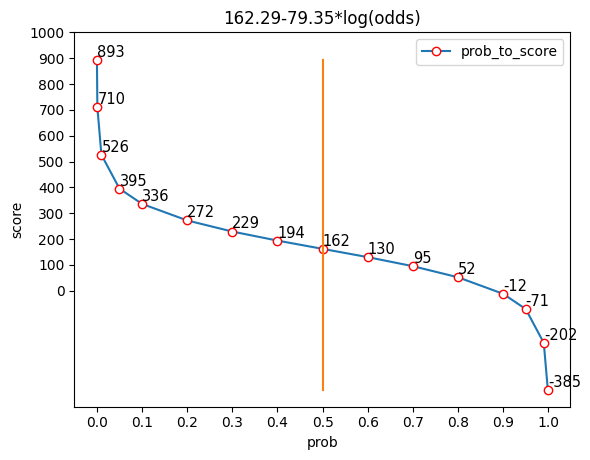

In [3]:

from sympy import *
import os

def prob_plot(score_prob,title,filepath):
    import matplotlib.pyplot as plt
    plt.plot(score_prob.prob, score_prob.score, marker='o', mec='r', mfc='w', label='prob_to_score')
    plt.legend(loc=0)
    plt.plot(np.ones(score_prob.shape[0]) * 0.5, score_prob.score, mfc='r')
    for c, d in zip(score_prob.prob, score_prob.score):
        plt.text(c, d + 0.3, str(round(d)), ha='left', va='bottom', fontsize=10.5)
    plt.xticks(np.arange(0.00, 1.01, 0.10))
    plt.yticks(np.arange(0, 1001, 100))
    # plt.margins(0)
    plt.subplots_adjust(bottom=0.10)
    plt.title(title)
    plt.xlabel('prob')
    plt.ylabel("score")
    plt.savefig((filepath + '/{title}.jpg').format(title=str(title)[-3:-1]),dpi=900)



def cfunc(ratio,basescore,double):
    x = Symbol('x')
    y = Symbol('y')
    out = solve([basescore -(x-y * np.log(ratio)), basescore -(x-y * np.log(2*ratio) + double)], [x, y])
    a = np.round(float(out.get(x)),2)
    b = np.round(float(out.get(y)),2)
    title = str(a) + '-' + str(b) + '*log(odds)'
    score_i = []
    score_j = []
    for i in np.arange(0.1,1.0,0.1):
        score_sig = out.get(x) - out.get(y) * np.log(i /(1-i))
        score_i.append(int(score_sig))
    score_prob = pd.DataFrame({'prob':np.arange(0.1,1.0,0.1),'score':score_i})
    for j in [0.0001,0.001,0.01,0.05,0.95,0.99, 0.999]:
        score_sig = out.get(x) - out.get(y) * np.log(j / (1 - j))
        # if score_sig > 1000:
        #     score_sig = 1000
        # elif score_sig < 300:
        #     score_sig = 300
        # else:
        #     score_sig = score_sig
        score_j.append(int(score_sig))
    score_prob_j = pd.DataFrame({'prob': [0.0001,0.001,0.01,0.05,0.95,0.99, 0.999], 'score': score_j})
    score_prob = score_prob._append(score_prob_j).sort_values(['prob'],ascending=False)
    # plot and save
    filepath = os.path.split(os.path.realpath('__file__'))[0] + '\output'
    if not os.path.exists(filepath):
        os.mkdir(filepath)
    prob_plot(score_prob, title,filepath)

    return score_prob


cfunc(0.05,400,55)

In [ ]:
def scoretofico(phat_final):
    '''
    phat_final: 预测概率
    '''
    logit_final = round(np.log(phat_final / (1 - phat_final)), 6)
    Pdo = 50
    Base = 500
    Odds = 0.1
    B = round((Pdo) / np.log(2), 6)  # Factor - B
    A = round(Base + (B * np.log(Odds)), 6)  # Offset - A    Base - 基础分

    APScore = round(max(min(A - B * logit_final, 1000), 0))

    return APScore


def scorecard(df_woe, df_weight, Pdo=50, Odds=0.1, Base=500):
    '''
    df_woe - 入模变量的变量名、分箱、总数、坏客户数、Woe值，通过optb获取
    df_weight - 各入模变量的系数（包含常数项'intercept_'）
    Pdo、Odds、Base根据数据情况和业务需求进行赋值
    本函数中的woe为坏比好
    '''
    B = round((Pdo) / np.log(2), 6)               #Factor - B
    A = round(Base + (B * np.log(Odds)), 6)

    # 拼接得到各变量的woe和系数
    df_res = pd.merge(df_woe, df_weight, how='left', on='variable')
    # 计算分数
    df_res['score'] = round((-B) * df_res['WoE'] * df_res['weight'])
    # 计算常数项分数
    intercept_score = round(A - B * (df_weight[df_weight['variable']=='intercept_']['weight'].values[0]))

    return df_res, intercept_score

In [ ]:
def max_min_score(df_woe, df_weight, best_score, worst_score):
    df1 = pd.merge(df_woe, df_weight, how='left', on='variable')
    df1['result'] = df1['WoE']*df1['weight']
    df2 = pd.DataFrame(df1.groupby(['variable']).agg({'result':['max','min']}))
    df2.columns=['woe_max','woe_min']
    df2 = df2.reset_index()
                                           
    # 得分上下限
    b0 = df_weight[df_weight['variable']=='intercept_']['weight'].values[0]
    max_ = b0 + sum(df2['woe_max'])
    min_ = b0 + sum(df2['woe_min'])
    
    B = -1 * (best_score - worst_score) / (max_ - min_)
    A = round(worst_score + B * min_, 6)
    
    df_res = pd.merge(df_woe, df_weight, how='left', on='variable')
    df_res['score'] = round((-B) * df_res['WoE'] * df_res['weight'], 6)
    intercept_score = round(A - B * b0, 6)
    
    return df_res, intercept_score, A, B, max_, min_

In [ ]:
# model_lr 为建立的LR模型
regression_cols = x_train3.columns.to_list()
regression_cols.append('intercept_')
print(len(regression_cols))
weight_value = list(lr_model.coef_.flatten())
weight_value.extend(list(lr_model.intercept_))
df_weight = pd.DataFrame()
df_weight['variable'] = regression_cols
df_weight['weight'] = weight_value
df_weight